# Shipments of medicines between 2007-2015 to Africa

LINK TO KAGGLE DATASET: https://www.kaggle.com/divyeshardeshana/supply-chain-shipment-pricing-data

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500

import preparation


%load_ext autoreload
%autoreload 2

In [2]:
# Load and fix data
df = pd.read_csv(".\\data\\SCMS_Delivery_History_Dataset.csv")
df = preparation.cleaning_input(df)

In [3]:
#plt.figure(figsize = (12, 5))
#sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = "viridis")
#plt.title("MISSING VALUES", fontsize =20)

for x in df.columns:
    if df[x].isna().sum() > 0:
        print("{} : {}  |  {:.2f} %".format(x, df[x].isna().sum(),
                                            df[x].isna().sum()/len(df)*100 ))             

PQ First Sent to Client Date : 205  |  1.99 %
PO Sent to Vendor Date : 205  |  1.99 %
Dosage : 1736  |  16.82 %
Weight (Kilograms) : 1604  |  15.54 %
Freight Cost (USD) : 344  |  3.33 %
Line Item Insurance (USD) : 287  |  2.78 %


## PRICE PREDICTION

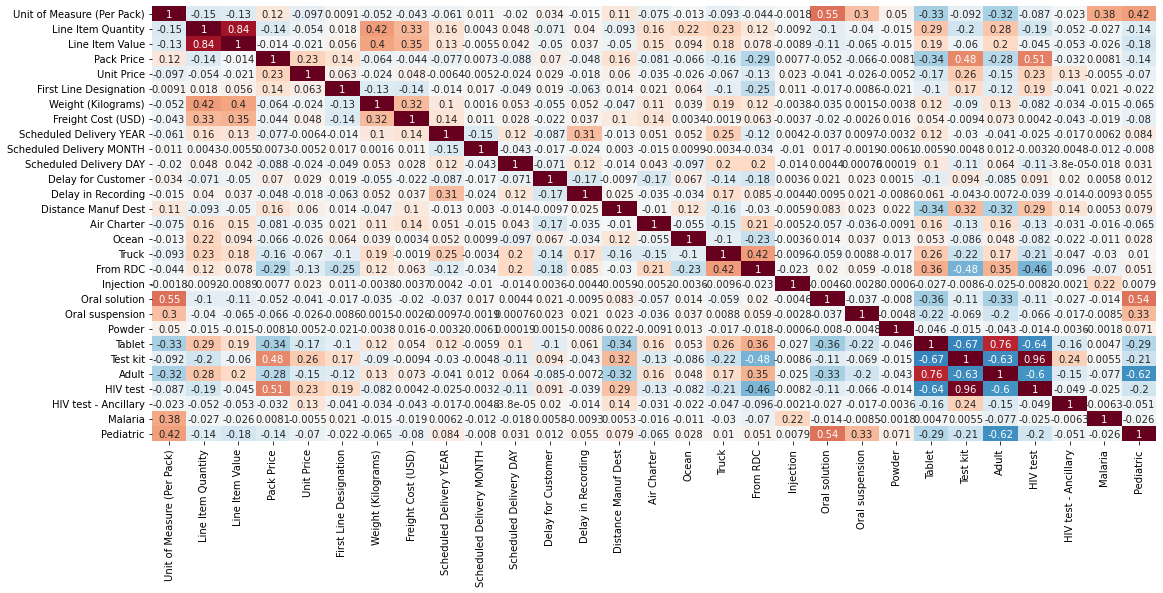

In [4]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error


XY = preparation.preprocessing_for_ml(df)

# NEW ANALYSIS OF CORRELATIONS
plt.figure(figsize = (18, 8))
sns.heatmap(preparation.preprocessing_for_ml(df).corr(),
            annot = True, cbar = False,
            vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.show()

In [5]:
X = XY.drop(["Unit Price", "Pack Price"], axis = 1).copy()
y = np.log(XY["Unit Price"] + 0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, random_state = 42)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
from sklearn.linear_model import LassoCV

lr = LassoCV(n_jobs = -1, random_state = 42)
lr.fit(X_train, y_train)

print(f"R^2: {r2_score(y_test, lr.predict(X_test)):.3f}")
print("MAPE: {:.2f} USD".format(mean_absolute_percentage_error(np.exp(y_test),
                                                               np.exp(lr.predict(X_test)))))

R^2: 0.631
MAPE: 0.73 USD


                      Feature Coefficient
0             Line Item Value    7.097997
1          Line Item Quantity   -5.744166
2  Unit of Measure (Per Pack)   -2.934866
3                    HIV test     1.61923
4             Oral suspension   -0.822185
5                     Malaria    0.538903
6                   Pediatric   -0.477012
7                   Injection     0.32531
8         Distance Manuf Dest   -0.318885
9                    From RDC   -0.290981


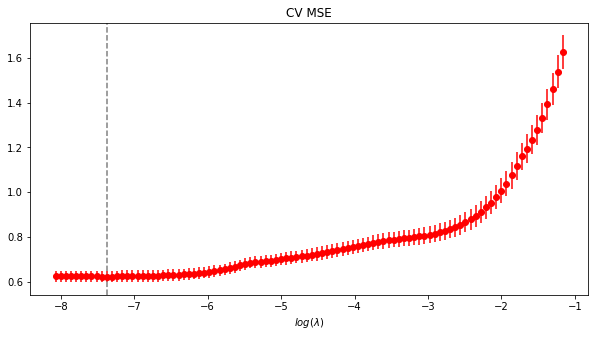

In [7]:
# Analysis of lasso
print(pd.DataFrame(np.c_[XY.drop(["Unit Price", "Pack Price"], axis = 1).columns, lr.coef_],
                   columns = ["Feature", "Coefficient"]).sort_values("Coefficient",
                                                                     key = lambda v: abs(v),
                                                                     ascending = False,
                                                                     ignore_index = True).head(10))

plt.figure(figsize = (10, 5))
plt.errorbar(np.log(lr.alphas_), lr.mse_path_.mean(axis = 1),
             yerr = lr.mse_path_.std(axis = 1), fmt = "o", color = "red")
plt.axvline(np.log(lr.alpha_), ls = "--", color = "grey")
plt.title("CV MSE")
plt.xlabel("$log(\lambda)$")
plt.show()

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(random_state = 42, criterion = "squared_error")
tree.fit(X_train, y_train)

ccp_path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

# Tree Pruning (we are overfitting - Accuracy: 100% in training)
tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                            for impty in np.linspace(max(0.1, impurities.min() + 0.01),
                                                     np.round(impurities.max()/2, 3),
                                                     num = 10)]}
tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 42,
                                               criterion = "squared_error"),
                         tree_params, cv = 3, n_jobs = 6, verbose = 10,
                         return_train_score = True)
tree_grid.fit(X_train, y_train)

forest = GradientBoostingRegressor(n_estimators = 50, loss = "squared_error",
                                   random_state = 42,
                                   ccp_alpha = tree_grid.best_estimator_.ccp_alpha)
forest.fit(X_train, y_train)

print(f"R^2: {r2_score(y_test, forest.predict(X_test)):.3f}")
print("MAPE: {:.2f} USD".format(mean_absolute_percentage_error(np.exp(y_test),
                                                               np.exp(forest.predict(X_test)))))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
R^2: 0.893
MAPE: 0.33 USD


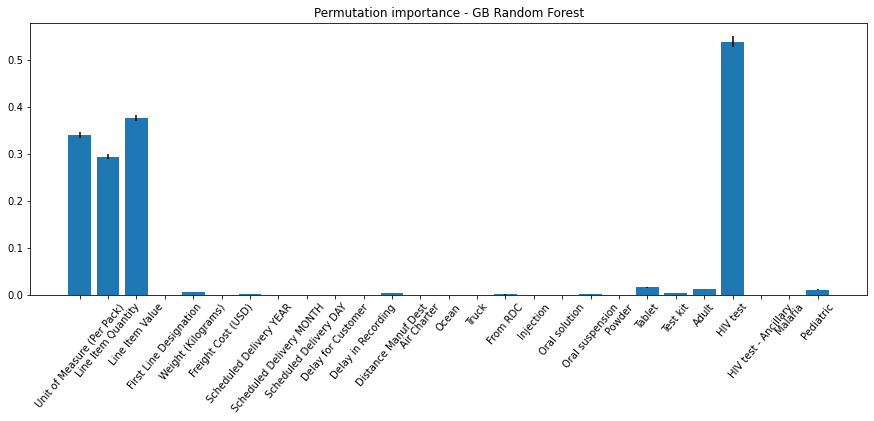

In [9]:
# Random Forest Analysis
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(forest, X_train, y_train, n_repeats = 50,
                                  n_jobs = -1, random_state = 42)

plt.figure(figsize = (15, 5))
plt.bar(x = XY.drop(["Unit Price", "Pack Price"], axis = 1).columns,
        height = perm_imp["importances_mean"],
        yerr = perm_imp["importances_std"])
plt.xticks(rotation = 50)
plt.title("Permutation importance - GB Random Forest")
plt.show()

## SHIPMENT MODE PREDICTION

In [10]:
XYSM = df.copy()
XYSM = preparation.preprocessing_for_classification(XYSM)


Xsm = XYSM.drop("Shipment Mode", axis = 1).copy()
ysm = XYSM["Shipment Mode"]

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(Xsm, ysm, train_size = .7,
                                                                random_state = 42)

scaler_sm = MinMaxScaler()
scaler_sm.fit(X_train_sm)

X_train_sm = scaler_sm.transform(X_train_sm)
X_test_sm = scaler_sm.transform(X_test_sm)

In [58]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV(Cs = 100, multi_class = "multinomial", n_jobs = -1,
                            solver = "saga", random_state = 42,
                            cv = 5, max_iter = 5e3, penalty = "l1")
logr.fit(X_train_sm, y_train_sm)

print(f"Accuracy: {accuracy_score(y_test_sm, logr.predict(X_test_sm)):.3f}")

Accuracy: 0.795


              Feature Coefficient Air Coefficient Air Charter  \
0  Weight (Kilograms)      -23.207766                7.199173   
1          Pack Price       22.935915               16.657401   
2  Line Item Quantity       -13.53376               -1.132729   
3  Delay in Recording        9.727651              -13.947788   
4          Unit Price         8.81348                0.925424   
5              Powder        5.200606               -0.492325   
6           Pediatric       -4.284886               -0.000449   
7               Adult       -4.123245                0.388284   
8  Freight Cost (USD)        3.451493                2.857479   
9  Delay for Customer        2.861703               -5.859321   

  Coefficient Ocean Coefficient Truck  
0         -7.798867          10.09523  
1        -36.591851          0.951991  
2          3.490703          0.974951  
3        -18.075817          8.271107  
4         -5.481488         -1.879715  
5         -0.180356         -0.250685  
6   

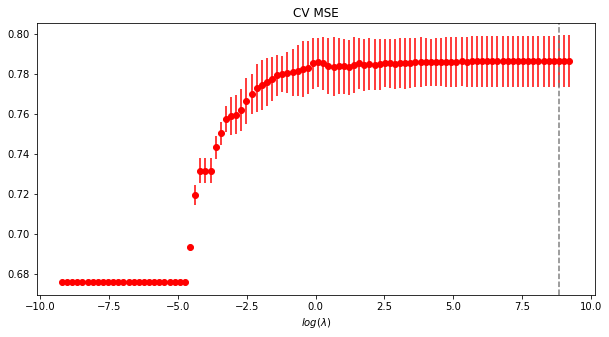

In [59]:
# Analysis of Logistic Regression
print(pd.DataFrame(np.c_[XYSM.drop("Shipment Mode", axis = 1).columns, logr.coef_.T],
                   columns = ["Feature", "Coefficient Air",
                              "Coefficient Air Charter", "Coefficient Ocean",
                              "Coefficient Truck"]).sort_values("Coefficient Air",
                                                                key = lambda v: abs(v),
                                                                ascending = False,
                                                                ignore_index = True).head(10))

plt.figure(figsize = (10, 5))
plt.errorbar(np.log(logr.Cs_), logr.scores_["Air"].mean(axis = 0),
             yerr = logr.scores_["Air"].std(axis = 0), fmt = "o", color = "red")
plt.axvline(np.log(logr.C_.mean()), ls = "--", color = "grey")
plt.title("CV MSE")
plt.xlabel("$log(\lambda)$")
plt.show()

In [ ]:
# PRICE OPTIMIZATION !!!!

In [ ]:
# Task of multi-class classification on SHIPMENT MODE

---
---
---